- https://arxiv.org/pdf/1208.0605.pdf
- https://arxiv.org/pdf/1305.0793.pdf
- https://www.lsst.org/science/dark-energy/shear_statistics
- https://arxiv.org/pdf/1904.13378.pdf

## TODO 
- [x] Include the mass-concentration relation
- [ ] Try to compute the mean of the bin according to the distribution of galaxies inside that bin
- [ ] Try to avoid WL simplification 
- [ ] Find the compromise between Mcut and alpha to maximize the SNR
- [ ] Verify the SNR of sheaer profile with CLMM mock data
- [ ] Verify and source the assumptions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from magnification_library import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import sys
sys.path.append('../CLMM/examples/support')
import clmm
import clmm.modeling as mod
from clmm import utils 
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit

In [3]:
from scipy.integrate import quad

In [4]:
from scipy import stats, interpolate

In [5]:
from colossus.cosmology import cosmology
from colossus.halo import concentration

In [6]:
#plotting functions

def plotting_2p_func(r3d, SNR1, SNR2, title, x_label='r [Mpc]', y1_label = '$SNR_{\mu, LBG} / SNR_{\gamma}$ ',  y2_label= '$SNR_{\mu, QSO} / SNR_{\gamma}$ ', sharey=False):
    
    fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=True, sharey=sharey)

    ax2.set_title(title, loc='left')

    for i in range(len(z_cl)):
        ax1.plot(r3d, SNR1[i,:], label = 'z_cl = '+str(z_cl[i]))
        ax2.plot(r3d, SNR2[i,:], label = 'z_cl = '+str(z_cl[i]))

    ax1.set_xscale('log')

    ax1.set_ylabel(y1_label);
    ax2.set_ylabel(y2_label);
    
    for i in (ax1,ax2):
        i.set_xlabel(x_label)
        i.grid()
        i.legend()
    
    fig.tight_layout()
    return fig, (ax1,ax2)


def plotting_3p_func(r3d, SNR1, SNR2, SNR3, title, x_label='r [Mpc]', y1_label = '$SNR_{\gamma}$',  y2_label='$SNR_{\mu, LBG}$',y3_label= '$SNR_{\mu, QSO}$', sharey=False):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(22,6), sharex=True, sharey=sharey)

    ax2.set_title(title, loc='left')

    for i in range(len(z_cl)):
        ax1.plot(r3d, SNR1[i,:], label = 'z_cl = '+str(z_cl[i]))
        ax2.plot(r3d, SNR2[i,:], label = 'z_cl = '+str(z_cl[i]))
        ax3.plot(r3d, SNR3[i,:], label = 'z_cl = '+str(z_cl[i]))

    ax1.set_xscale('log')

    ax1.set_ylabel(y1_label);
    ax2.set_ylabel(y2_label);
    ax3.set_ylabel(y3_label);

    for i in (ax1,ax2,ax3):
        i.set_xlabel(x_label)
        i.grid()
        i.legend()
    
    fig.tight_layout()
    return fig, (ax1,ax2,ax3)


In [7]:
#define cosmology
params = {'flat': True, 'H0': 71., 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.80, 'ns': 0.963}

#astropy
cosmo = FlatLambdaCDM(H0=params['H0'], Om0=params['Om0'], Ob0=params['Ob0'], Tcmb0=0, Neff=3.04)

#ccl like
cosmo_ccl = mod.cclify_astropy_cosmo(cosmo)

#colossus
cosmology.addCosmology('myCosmo', params)
cosmo_colossus = cosmology.setCosmology('myCosmo')

### The SNR for the shear is  SNR$_{\gamma} = \sqrt{N_{\gamma}}\frac{|\gamma|}{\sigma_e} = \sqrt{N_{\gamma}}\frac{|\beta_s(z_s)\gamma_\inf|}{\sigma_e}$

### The SNR for the magnification is  SNR$_{\mu} = (\mu^{(\alpha - 1)} - 1)\sqrt{N_{\mu}} \approx 2(\alpha -1 )\kappa \sqrt{N_{\mu}} = \beta_s(z_s) 2(\alpha -1 )\kappa_{inf} \sqrt{N_{\mu}}$

### with $\beta_s(z_s) = \frac{D_{LS}}{D_S}\frac{D_{\inf}}{D_{L,\inf}}$

# **1) Lens and sources properties**

In [70]:
#lens properties 
z_cl = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]
mass = np.array([5e13, 1e14, 2.5e14, 5e14,1e15])
#concentration = 3.

r200, r500, c200 = np.zeros((3, len(mass), len(z_cl)))
for i in range(len(z_cl)):
    r200[:, i] = scaled_radius(200, mass, z_cl[i], cosmo)
    r500[:, i] = scaled_radius(500, mass, z_cl[i], cosmo)
    c200[:, i] = concentration.modelDiemer19(mass*cosmo.h, z_cl[i], statistic='mean')[0]

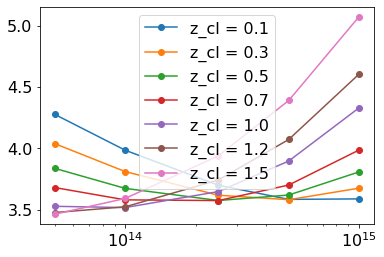

In [71]:
for i in range(len(z_cl)):
    plt.plot(mass, c200[:,i], 'o-',  label = 'z_cl = '+str(z_cl[i]))
plt.xscale('log')

plt.legend()

In [94]:
#Source galaxies properties

#SHEAR LSST
#s_e = 0.22
#n_e = 50. / u.arcmin**2
s_e = 0.26
n_e = 26 /u.arcmin**2
#shear_pdz = pzfxn

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3)/norm

#MAGNIFICATION DESI
alpha_qso =  2.5 *0.196 #for QSO
n_eff_qso = (170/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin))

def mu_qso_pdz(z):
    norm =quad(QSO_pdf_z, 0, np.inf)[0]
    return QSO_pdf_z(z)/norm

#MAGNIFICATION LSST
#alpha_lbg =  2.06 #for lgb
#n_eff_lbg = 0.16/(u.arcmin*u.arcmin)
alpha_lbg = 2.5 * slope(25.5, -1.78, 24.7, beta=None,fct="schechter") #see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout
n_eff_lbg = (1e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) #see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

def mu_lbg_pdz(z):
    return gaussian(z, 1, 3.3,0.25)/quad(lambda z: gaussian(z, 1, 3.3,0.25), 0, np.inf)[0]

In [95]:
#computation utils properties
z_s = np.linspace(0.001, 4, 40)
zinf = 1e10 

conv = cosmo.arcsec_per_kpc_proper(z_s) #.to(u.arcmin/u.Mpc)  #.to(u.deg/u.Mpc)
conv_cl = cosmo.arcsec_per_kpc_proper(z_cl)
inv_conv_cl = cosmo.kpc_proper_per_arcmin(z_cl)

#r3d = np.logspace(-2, 2, 100)
r3d = np.linspace(0.01, 10, 1000)

A = 1.*u.Mpc**2

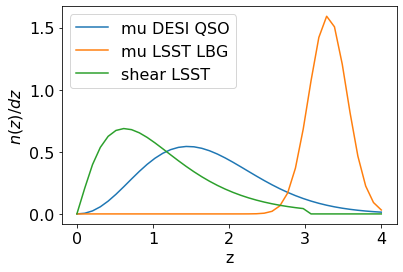

In [96]:
plt.plot(z_s, mu_qso_pdz(z_s), label = 'mu DESI QSO')
plt.plot(z_s, mu_lbg_pdz(z_s), label = 'mu LSST LBG')
plt.plot(z_s, shear_pdz(z_s), label = 'shear LSST')

plt.xlabel('z')
plt.ylabel("$n(z)/dz$")
plt.legend();

In [97]:
print ("Source densities : ", n_e, "for LSST shear;", round(n_eff_qso.value,2)*n_eff_qso.unit, "for DESI QSO;", round(n_eff_lbg.value,2)*n_eff_lbg.unit, "for LSST LBG;")

Source densities :  26.0 1 / arcmin2 for LSST shear; 0.05 1 / arcmin2 for DESI QSO; 2.78 1 / arcmin2 for LSST LBG;


In [98]:
Ngal_s      = shear_pdz(z_s)  * (n_e *       A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_qso = mu_qso_pdz(z_s) * (n_eff_qso * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_lbg = mu_lbg_pdz(z_s) * (n_eff_lbg * A * (conv.to(u.arcmin/u.Mpc))**2).value

In [99]:
from scipy.integrate import cumtrapz

In [100]:
cum_Ngal_s      =  cumtrapz(Ngal_s, z_s,initial=0)
cum_Ngal_mu_qso =  cumtrapz(Ngal_mu_qso, z_s,initial=0)
cum_Ngal_mu_lbg =  cumtrapz(Ngal_mu_lbg, z_s,initial=0)

# $\frac{N_{s}}{dz} = \frac{d n_{eff}}{dz}.A(z) $   

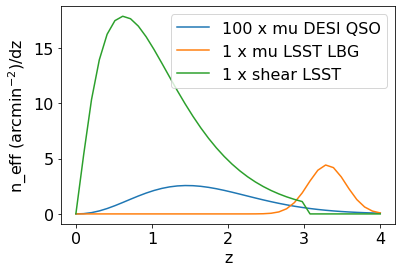

In [101]:
n1, n2, n3 = 100, 1, 1

plt.plot(z_s, n1*mu_qso_pdz(z_s)*n_eff_qso.value, label = str(n1)+' x mu DESI QSO')
plt.plot(z_s, n2*mu_lbg_pdz(z_s)*n_eff_lbg.value, label = str(n2)+' x mu LSST LBG')
plt.plot(z_s, n3*shear_pdz(z_s)*n_e.value, label = str(n3)+' x shear LSST')

plt.xlabel('z')
plt.ylabel("n_eff (arcmin$^{-2}$)/dz")
plt.legend();

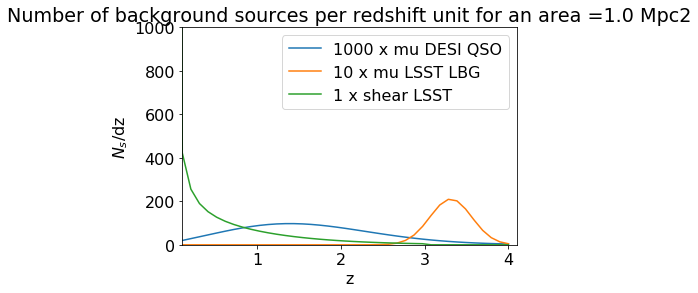

In [102]:
n1, n2, n3 = 1000, 10, 1

plt.title("Number of background sources per redshift unit for an area ="+str(A))

plt.plot(z_s, n1*Ngal_mu_qso, label = str(n1)+' x mu DESI QSO')
plt.plot(z_s, n2*Ngal_mu_lbg, label = str(n2)+' x mu LSST LBG')
plt.plot(z_s, n3*Ngal_s,label = str(n3)+' x shear LSST')

plt.xlabel('z')
plt.ylabel("$N_s$/dz")
plt.legend()

plt.xlim(0.1,4.1)
plt.ylim(0,1000);

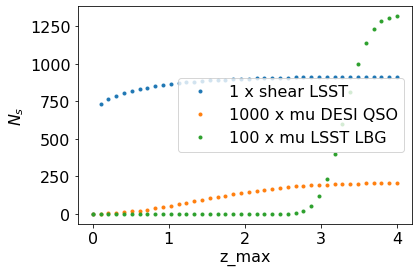

In [103]:
n1, n2, n3 = 1000, 100, 1

plt.plot(z_s, n3* cum_Ngal_s,'.',label = str(n3)+' x shear LSST')
plt.plot(z_s, n1* cum_Ngal_mu_qso,'.', label = str(n1)+' x mu DESI QSO')
plt.plot(z_s, n2* cum_Ngal_mu_lbg,'.', label = str(n2)+' x mu LSST LBG')


plt.xlabel('z_max')
plt.ylabel("$N_s$")
plt.legend();

#plt.yscale('log')


# **2) WL model computation**

## **Shear and convergence profiles**

In [104]:
kappa_inf = np.zeros((r3d.size, len(mass), len(z_cl)))
shear_inf = np.zeros((r3d.size, len(mass), len(z_cl)))


for i in range(len(z_cl)):
    for j in range(len(mass)):
        kappa_inf[:, j, i] = mod.predict_convergence(r3d*cosmo.h, mdelta=mass[j]*cosmo.h, cdelta=c200[j,i], 
                                        z_cluster=z_cl[i], z_source=zinf, cosmo=cosmo_ccl, 
                                        delta_mdef=200, 
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane')
    
        shear_inf[:, j, i] = mod.predict_tangential_shear(r3d*cosmo.h, mdelta=mass[j]*cosmo.h, cdelta=c200[j,i], 
                                        z_cluster=z_cl[i], z_source=zinf, cosmo=cosmo_ccl, 
                                        delta_mdef=200, 
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane')

## $ \frac{|\gamma_\inf|}{\kappa_{inf}} = \frac{\Delta\Sigma (R)} {\Sigma (R)}$

In [105]:
#shear_inf_m, kappa_inf_m = shear_inf, kappa_inf

In [106]:
#r200_m = scaled_radius(200, 1e14, z_cl, cosmo)

No handles with labels found to put in legend.


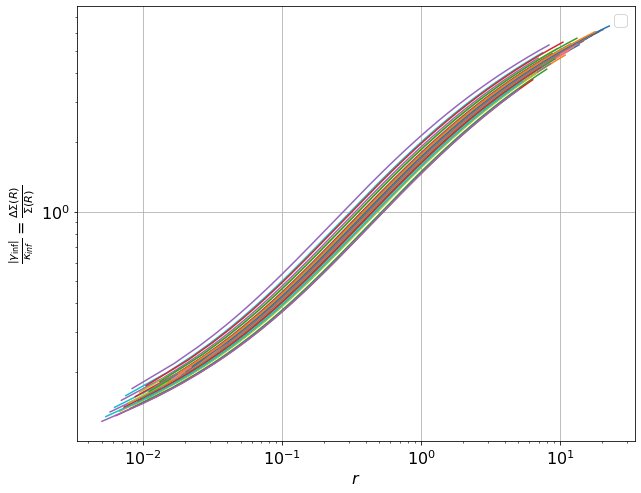

In [107]:
#ratio of shear over convergence
plt.figure(figsize=(10,8))

for i in range(len(z_cl)):
    for j in range(len(mass)):
        plt.plot(r3d/r200[j, i], shear_inf[:,j, i]/kappa_inf[:,j, i])#,label = str(mass[j]/1e14) + 'z_cl = '+str(z_cl[i]))
    

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel('$r$')
plt.ylabel('$\\frac{|\gamma_\inf|}{\kappa_{inf}} = \\frac{\Delta\Sigma (R)} {\Sigma (R)}$');
plt.grid()

## **Redshift distribution**

# $\beta_s(z_s) = \frac{D_{LS}}{D_S}\frac{D_{\inf}}{D_{L,\inf}}$

In [108]:
B = np.zeros((len(z_cl), z_s.size))
Bs = np.zeros((len(z_cl), z_s.size))

for i in range(len(z_cl)):
    B[i,:] = beta(z_cl[i], z_s, cosmo)
    Bs[i,:] = beta_s(z_cl[i], z_s, zinf, cosmo)

# $<\beta_s(z_s)> = <\frac{D_{LS}}{D_S}>\frac{D_{\inf}}{D_{L,\inf}}$
# $<\beta(z_s)> = <\frac{D_{LS}}{D_S}> = \frac{\int_{z_{s,min}}^{z_{s,max}} n(z) \beta(z)  \mathrm{d}z}{\int_{z_{s,min}}^{z_{s,max}} n(z)  \mathrm{d}z} $

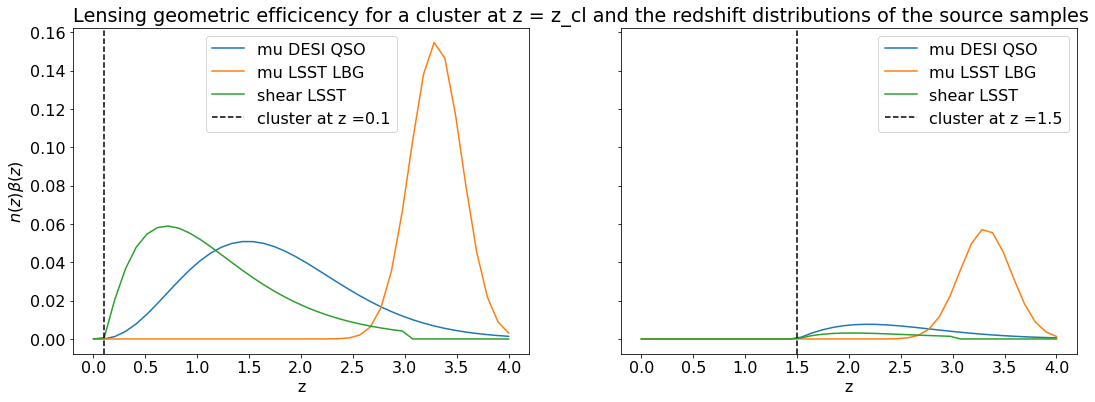

In [109]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=True, sharey=True)


ax1.set_title('Lensing geometric efficicency for a cluster at z = z_cl and the redshift distributions of the source samples', loc='left')

i = 0
ax1.plot(z_s, B[i,:] * mu_qso_pdz(z_s)*z_s[1], label = 'mu DESI QSO')
ax1.plot(z_s, B[i,:] * mu_lbg_pdz(z_s)*z_s[1], label = 'mu LSST LBG')
ax1.plot(z_s, B[i,:] * shear_pdz(z_s)*z_s[1], label = 'shear LSST')
ax1.axvline(z_cl[i], color='black',linestyle="dashed", label = 'cluster at z ='+str(z_cl[i]))

ax1.set_ylabel("$n(z) \\beta(z)$")
ax1.set_xlabel('z')
ax1.legend();

i = 6
ax2.plot(z_s, B[i,:] * mu_qso_pdz(z_s)*z_s[1], label = 'mu DESI QSO')
ax2.plot(z_s, B[i,:] * mu_lbg_pdz(z_s)*z_s[1], label = 'mu LSST LBG')
ax2.plot(z_s, B[i,:] * shear_pdz(z_s)*z_s[1], label = 'shear LSST')
ax2.axvline(z_cl[i], color='black',linestyle="dashed", label = 'cluster at z ='+str(z_cl[i]))

ax2.set_xlabel('z')
ax2.legend();

In [110]:
B_mean = np.zeros((3, len(z_cl)))
B2_mean = np.zeros((3, len(z_cl)))
Bs_mean = np.zeros((3, len(z_cl)))

pdz = [ shear_pdz,  mu_lbg_pdz, mu_qso_pdz]

for i in range(len(z_cl)):

    B_mean[0, i] = compute_B_mean(z_cl[i], pdz[0], cosmo)
    B_mean[1, i] = compute_B_mean(z_cl[i], pdz[1], cosmo)
    B_mean[2, i] = compute_B_mean(z_cl[i], pdz[2], cosmo)
    
    Bs_mean[0, i] = B_mean[0, i] / beta(z_cl[i],zinf,cosmo)
    Bs_mean[1, i] = B_mean[1, i] / beta(z_cl[i],zinf,cosmo)
    Bs_mean[2, i] = B_mean[2, i] / beta(z_cl[i],zinf,cosmo)
    
    B2_mean[0, i] = np.sum( B[i,:]**2 * pdz[0](z_s)) / np.sum(pdz[0](z_s))
    B2_mean[1, i] = np.sum( B[i,:]**2 * pdz[1](z_s)) / np.sum(pdz[1](z_s))
    B2_mean[2, i] = np.sum( B[i,:]**2 * pdz[2](z_s)) / np.sum(pdz[2](z_s))    
    
B_mean_shear, B_mean_mu_LBG, B_mean_mu_qso = B_mean
Bs_mean_shear, Bs_mean_mu_LBG, Bs_mean_mu_qso = Bs_mean
B2_mean_shear, B2_mean_mu_LBG, B2_mean_mu_qso, = B2_mean

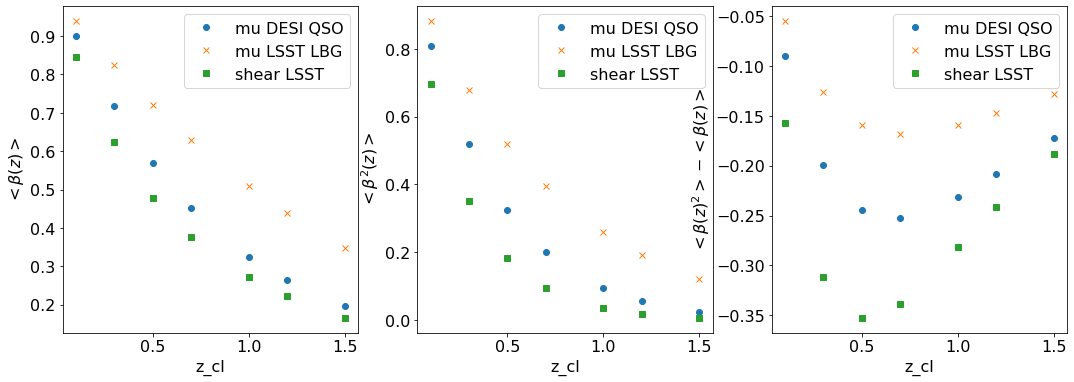

In [111]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(18,6), sharex=True)

ax1.plot(z_cl, B_mean_mu_qso, 'o', label = 'mu DESI QSO')
ax1.plot(z_cl, B_mean_mu_LBG, 'x', label = 'mu LSST LBG')
ax1.plot(z_cl, B_mean_shear, 's',  label = 'shear LSST')

ax1.set_ylabel("$<\\beta(z)>$")
ax1.set_xlabel('z_cl')
ax1.legend();

ax2.plot(z_cl, B2_mean_mu_qso, 'o', label = 'mu DESI QSO')
ax2.plot(z_cl, B2_mean_mu_LBG, 'x', label = 'mu LSST LBG')
ax2.plot(z_cl, B2_mean_shear, 's',  label = 'shear LSST')

ax2.set_ylabel("$<\\beta^2(z)>$")
ax2.set_xlabel('z_cl')
ax2.legend();

#Eq.12 in https://arxiv.org/pdf/1611.03866.pdf and Eq.6 and note in https://academic.oup.com/mnras/article/439/1/48/963939
ax3.plot(z_cl, (B2_mean_mu_qso/B_mean_mu_qso -1)*B_mean_mu_qso, 'o', label = 'mu DESI QSO')
ax3.plot(z_cl, (B2_mean_mu_LBG/B_mean_mu_LBG -1)*B_mean_mu_qso, 'x', label = 'mu LSST LBG')
ax3.plot(z_cl, (B2_mean_shear/B_mean_shear -1)*B_mean_mu_qso, 's',  label = 'shear LSST')

ax3.set_ylabel("$<\\beta(z)^2> - <\\beta(z)> $")
ax3.set_xlabel('z_cl')
ax3.legend();

### The corrections of the form $<\beta(z)^2> - <\beta(z)> $ are negligeable. Thus we use $<g> \approx <\gamma> \approx <\beta_s>\gamma_{inf}$

# **3) SNR computation**

### **SNR as a function of radius, wihout explicit binning**

In [112]:
j = 2

#SNR for a fixed area in arcmin**2
SNR_s_fix_ang = np.zeros((len(z_cl), r3d.size))
SNR_mu_qso_fix_ang = np.zeros((len(z_cl), r3d.size))
SNR_mu_lbg_fix_ang = np.zeros((len(z_cl), r3d.size))

#SNR for a fixed area in Mpc**2
SNR_s_fix_phys = np.zeros((len(z_cl), r3d.size))
SNR_mu_qso_fix_phys = np.zeros((len(z_cl), r3d.size))
SNR_mu_lbg_fix_phys = np.zeros((len(z_cl), r3d.size))

#SNR for an area following the size of annulus in arcmin**2
SNR_s_ang = np.zeros((len(z_cl), r3d.size))
SNR_mu_qso_ang = np.zeros((len(z_cl), r3d.size))
SNR_mu_lbg_ang = np.zeros((len(z_cl), r3d.size))

#SNR for an area following the size of annulus in Mpc**2
SNR_s_phys = np.zeros((len(z_cl), r3d.size))
SNR_mu_qso_phys = np.zeros((len(z_cl), r3d.size))
SNR_mu_lbg_phys = np.zeros((len(z_cl), r3d.size))



ang_area = (0.1*u.arcmin**2).value

phys_area = (0.1*u.Mpc**2).value


for i in range(len(z_cl)):
    
    phys_area_cl = phys_area *  ((conv_cl.to(u.arcmin/u.Mpc))**2).value
    
    theta_phys =    r3d * conv_cl[i].to(u.arcmin/u.Mpc).value
    dr_phys =       0.01 * (u.Mpc * conv_cl[i].to(u.arcmin/u.Mpc)).value
    area_eqw_phys = 2*np.pi*theta_phys*dr_phys #arcmin**2
    
    theta_ang =   (np.linspace(2e-2,50, r3d.size) * (u.arcmin)).value
    dr_ang = (0.2 * (u.arcmin)).value
    area_eqw_ang = 2*np.pi*theta_ang*dr_ang #arcmin**2
    
    Ngal_s      = quad(shear_pdz , z_cl[i] + 0.1, np.inf)[0] * (n_e *       area_eqw_phys).value
    Ngal_mu_qso = quad(mu_qso_pdz, z_cl[i] + 0.1, np.inf)[0] * (n_eff_qso * area_eqw_phys).value
    Ngal_mu_lbg = quad(mu_lbg_pdz, z_cl[i] + 0.1, np.inf)[0] * (n_eff_lbg * area_eqw_phys).value

    SNR_s_fix_ang[i,:]      = SNR_shear(Bs_mean_shear[i] * shear_inf[:, j, i] , ang_area * Ngal_s      / area_eqw_phys,      s_e)
    SNR_mu_qso_fix_ang[i,:] = SNR_mag(Bs_mean_mu_qso[i]  * kappa_inf[:, j, i] , ang_area * Ngal_mu_qso / area_eqw_phys, alpha_qso)
    SNR_mu_lbg_fix_ang[i,:] = SNR_mag(Bs_mean_mu_LBG[i]  * kappa_inf[:, j, i] , ang_area * Ngal_mu_lbg / area_eqw_phys, alpha_lbg)
    
    SNR_s_fix_phys [i,:]      = SNR_shear(Bs_mean_shear[i]*shear_inf[:,j,  i], phys_area_cl[i] * Ngal_s      / area_eqw_phys , s_e)
    SNR_mu_qso_fix_phys [i,:] = SNR_mag(Bs_mean_mu_qso[i]*kappa_inf[:,j,  i] , phys_area_cl[i] * Ngal_mu_qso / area_eqw_phys , alpha_qso)
    SNR_mu_lbg_fix_phys [i,:] = SNR_mag(Bs_mean_mu_LBG[i]*kappa_inf[:,j,  i] , phys_area_cl[i] * Ngal_mu_lbg / area_eqw_phys , alpha_lbg)
    
    SNR_s_ang[i,:]      = SNR_shear(Bs_mean_shear[i]*shear_inf[:,j,  i], area_eqw_ang * Ngal_s      / area_eqw_phys, s_e)
    SNR_mu_qso_ang[i,:] = SNR_mag(Bs_mean_mu_qso[i] *kappa_inf[:, j, i], area_eqw_ang * Ngal_mu_qso / area_eqw_phys, alpha_qso)
    SNR_mu_lbg_ang[i,:] = SNR_mag(Bs_mean_mu_LBG[i] *kappa_inf[:, j, i], area_eqw_ang * Ngal_mu_lbg / area_eqw_phys, alpha_lbg)
    
    SNR_s_phys[i,:]      = SNR_shear(Bs_mean_shear[i]*shear_inf[:, j, i], Ngal_s     , s_e)
    SNR_mu_qso_phys[i,:] = SNR_mag(Bs_mean_mu_qso[i] *kappa_inf[:, j, i], Ngal_mu_qso, alpha_qso)
    SNR_mu_lbg_phys[i,:] = SNR_mag(Bs_mean_mu_LBG[i] *kappa_inf[:, j, i], Ngal_mu_lbg, alpha_lbg)
    
    
    

## **SNR for a fixed angular area in arcmin^2**

In [113]:
print ("area = ", ang_area, "arcmin^2")

area =  0.1 arcmin^2


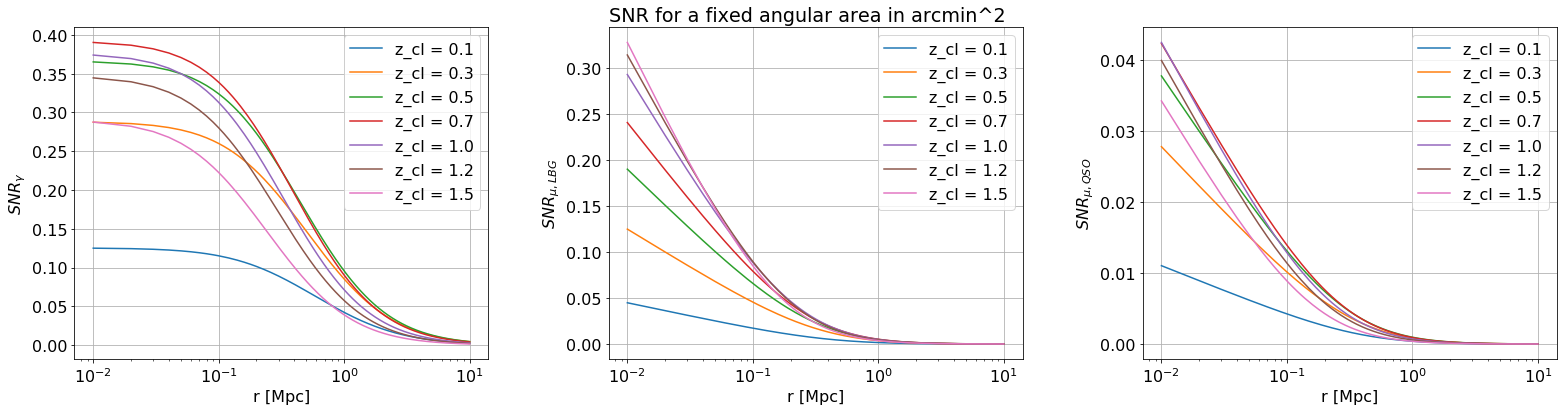

In [114]:
fig, (ax1, ax2, ax3) = plotting_3p_func(r3d, SNR_s_fix_ang, SNR_mu_lbg_fix_ang, SNR_mu_qso_fix_ang, 'SNR for a fixed angular area in arcmin^2')

## **SNR for a fixed area in physical size (Mpc^2)**

## **SNR for an area of equal annulus in arcmin**

## **SNR for an area of equal annulus in Mpc**

In [115]:
print ("width = ", dr_phys, "Mpc^2")

width =  0.019432535936343694 Mpc^2


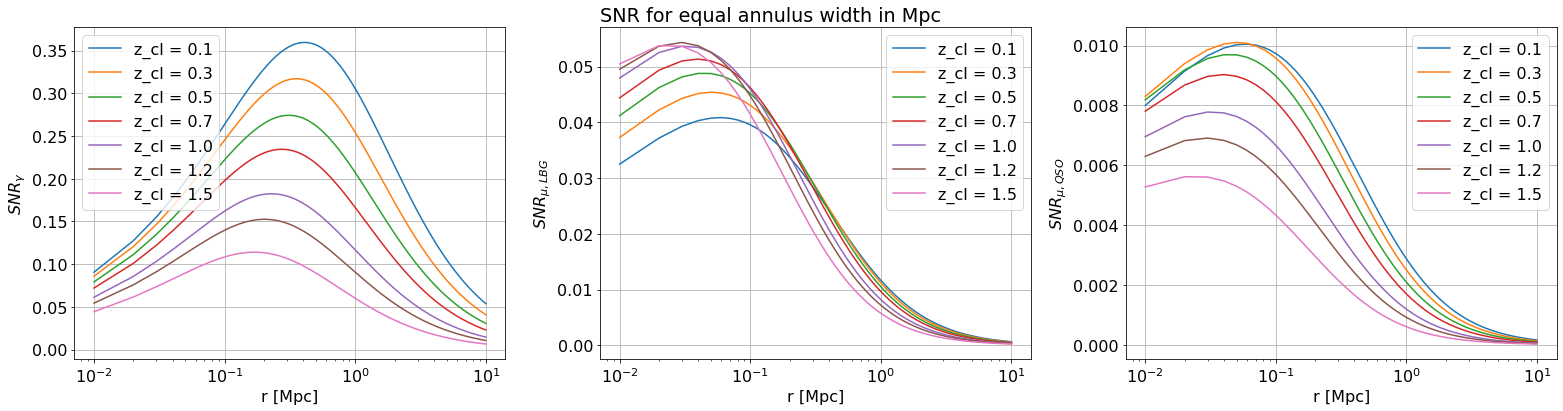

In [117]:
fig, (ax1, ax2, ax3) = plotting_3p_func(r3d, SNR_s_phys, SNR_mu_lbg_phys, SNR_mu_qso_phys, 'SNR for equal annulus width in Mpc')

## **SNR of user defined binning**

This is equivalent as the profiles presented before for : rmin=0.01-0.005, rmax = 10+0.005, nbins=1000, method='evenwidth'

In [118]:
dict_profile = {'reduced shear': \
                {'model_func':  mod.predict_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': shear_pdz,\
                'source_density': n_e}, \
                'magnification LBG': \
                {'model_func':  mod.predict_convergence, \
                'noise_func': noise_mag,\
                'model_arg': 2 * abs(alpha_lbg - 1), \
                'source_pdz': mu_lbg_pdz,\
                'source_density': n_eff_lbg}, \
                'magnification QSO': \
                {'model_func':  mod.predict_convergence, \
                'noise_func': noise_mag,\
                'model_arg': 2 * abs(alpha_qso - 1), \
                'source_pdz': mu_qso_pdz,\
                'source_density': n_eff_qso} }

In [119]:
lens_redshift = 1.
radial_unit, rmin, rmax, nbins, method= 'Mpc', 0.2, 5., 5, 'evenlog10width'
#radial_unit, rmin, rmax =  'arcmin', 0.2, 50
profile_type = "reduced shear"

In [120]:
bin_center, bin_edges, model, noise = profile_determination(rmin, rmax, radial_unit , lens_redshift, mass , profile_type , dict_profile, cosmo, nbins=nbins, method=method, conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift, statistic='mean')[0], delta_mdef=200, zinf=1e10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


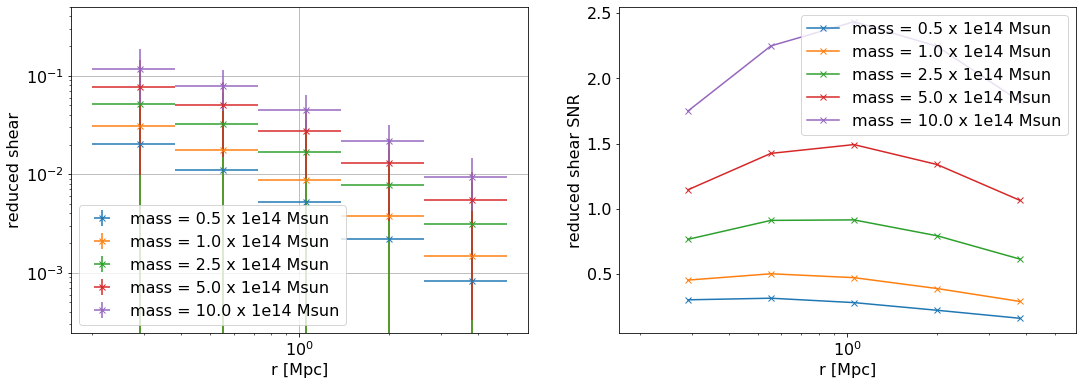

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=True, sharey=False)

for i in range(len(mass)):
    ax1.errorbar(bin_center, model[:,i], xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center], yerr = noise ,fmt='x', label = 'mass = '+str(mass[i]/1e14) + ' x 1e14 Msun')
    ax2.plot(bin_center, model[:,i]/noise, 'x-', label = 'mass = '+str(mass[i]/1e14) + ' x 1e14 Msun')

ax1.legend()
ax2.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylim(0, 0.5)

ax1.grid()

ax1.set_ylabel(profile_type)
ax1.set_xlabel('r [' + radial_unit + ']');

ax2.set_ylabel(profile_type + " SNR")
ax2.set_xlabel('r [' + radial_unit + ']');

In [122]:
lens_redshift = z_cl
radial_unit, rmin, rmax = 'Mpc', 0.01, 20
nbins = 20
#radial_unit, rmin, rmax =  'arcmin', 0.2, 50
method = 'evenlog10width'

In [123]:
bin_center_s, noise_s = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_s = np.zeros((nbins + 1, len(lens_redshift)))
model_s = np.zeros((nbins, len(mass), len(lens_redshift)))

for i in range(len(lens_redshift)):
    bin_center_s[:,i], bin_edges_s[:,i], model_s[:,:,i], noise_s[:,i] = profile_determination(rmin, rmax, radial_unit , lens_redshift[i], mass , "reduced shear" ,\
                                                                                              dict_profile, cosmo, nbins=nbins, method=method, \
                                                                                              conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200)

In [124]:
bin_center_mu_lbg, noise_mu_lbg = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_lbg = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_lbg = np.zeros((nbins, len(mass), len(lens_redshift)))

for i in range(len(lens_redshift)):
    bin_center_mu_lbg[:,i], bin_edges_mu_lbg[:,i], model_mu_lbg[:,:,i], noise_mu_lbg[:,i] = profile_determination(rmin, rmax, radial_unit , lens_redshift[i], mass , "magnification LBG" ,\
                                                                                                                  dict_profile, cosmo,   nbins=nbins, method=method, \
                                                                                                                  conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200)

In [125]:
bin_center_mu_qso, noise_mu_qso = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_qso = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_qso = np.zeros((nbins, len(mass), len(lens_redshift)))

for i in range(len(lens_redshift)):
    bin_center_mu_qso[:,i], bin_edges_mu_qso[:,i], model_mu_qso[:,:,i], noise_mu_qso[:,i] = profile_determination(rmin, rmax, radial_unit , lens_redshift[i], mass , "magnification QSO" ,\
                                                                                                                  dict_profile, cosmo,   nbins=nbins, method=method , \
                                                                                                                  conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200)

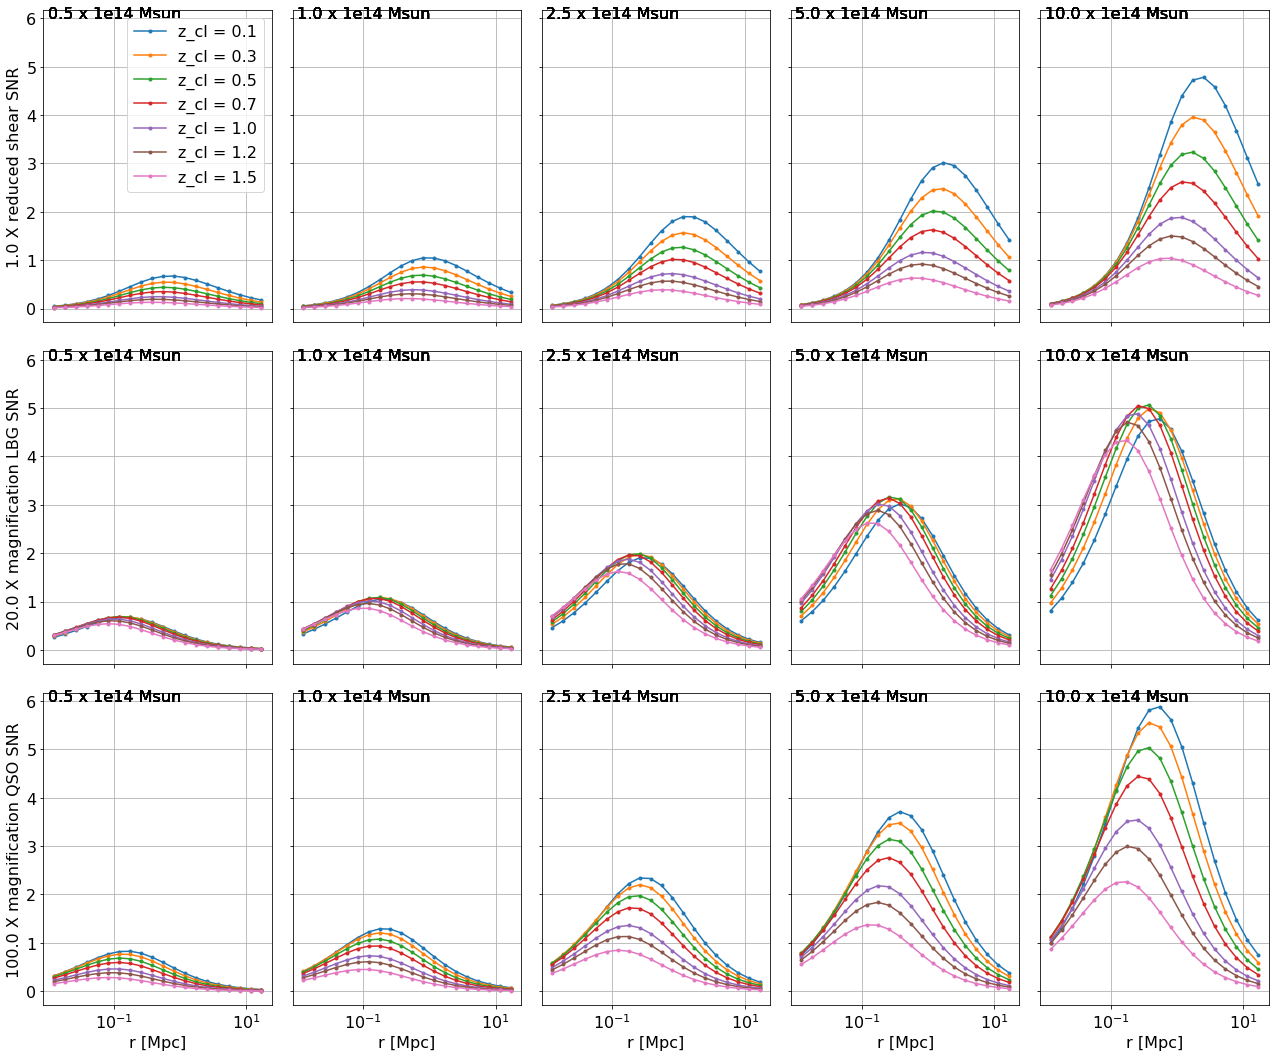

In [126]:
fig, ax = plt.subplots(3, len(mass),  figsize=(18,15), sharex=True, sharey=True)

N_shear, N_mu_lbg, N_mu_qso = 1.0, 20., 100.

for j in range(len(lens_redshift)):
    for i in range(len(mass)):  
        #ax1.errorbar(bin_center, model[:,i], xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center], yerr = noise ,fmt='x', label = 'mass = '+str(mass[i]/1e14) + ' x 1e14 Msun')
        ax[0,i].plot(bin_center_s[:,j],      N_shear * model_s[:,i, j]/noise_s[:,j],            '.-',  label = 'z_cl = '+str(lens_redshift[j]))
        ax[1,i].plot(bin_center_mu_lbg[:,j], N_mu_lbg * model_mu_lbg[:,i, j]/noise_mu_lbg[:,j], '.-',  label = 'z_cl = '+str(lens_redshift[j]))
        ax[2,i].plot(bin_center_mu_qso[:,j], N_mu_qso * model_mu_qso[:,i, j]/noise_mu_qso[:,j], '.-',  label = 'z_cl = '+str(lens_redshift[j]))
        ax[2,i].set_xlabel('r [' + radial_unit + ']');
        
        [ax[k,i].text(0.01,6, str(mass[i]/1e14) + ' x 1e14 Msun') for k in [0,1,2]]
        [ax[k,i].grid() for k in [0,1,2]]
    
ax[0,0].legend()
ax[0,0].set_xscale('log')

ax[0,0].set_ylabel(str(N_shear)  + " X reduced shear" + " SNR")
ax[1,0].set_ylabel(str(N_mu_lbg) + " X magnification LBG" + " SNR")
ax[2,0].set_ylabel(str(N_mu_qso) + " X magnification QSO" + " SNR")

fig.tight_layout()

# **SNR RATIO**

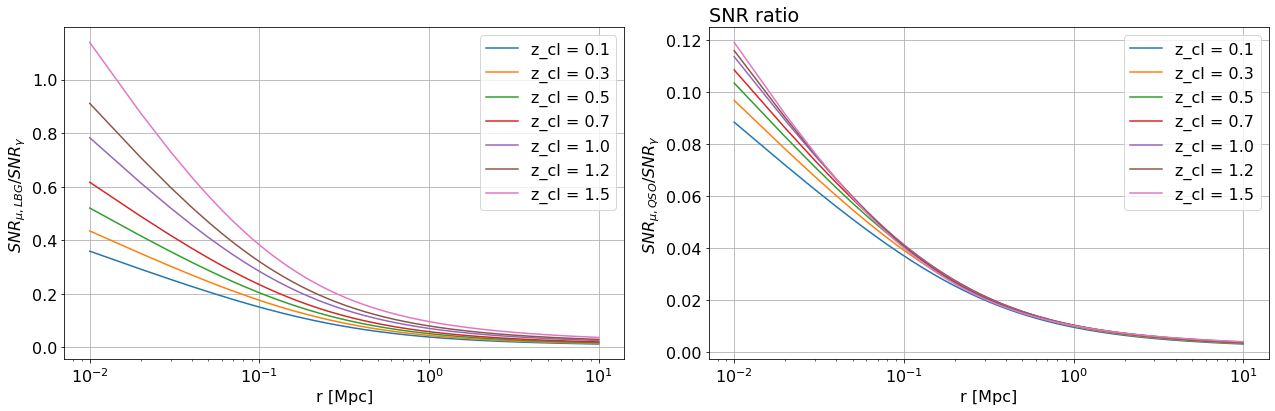

In [128]:
fig, (ax1, ax2) = plotting_2p_func(r3d, SNR_mu_lbg_ang/SNR_s_ang, SNR_mu_qso_ang/SNR_s_ang,'SNR ratio')

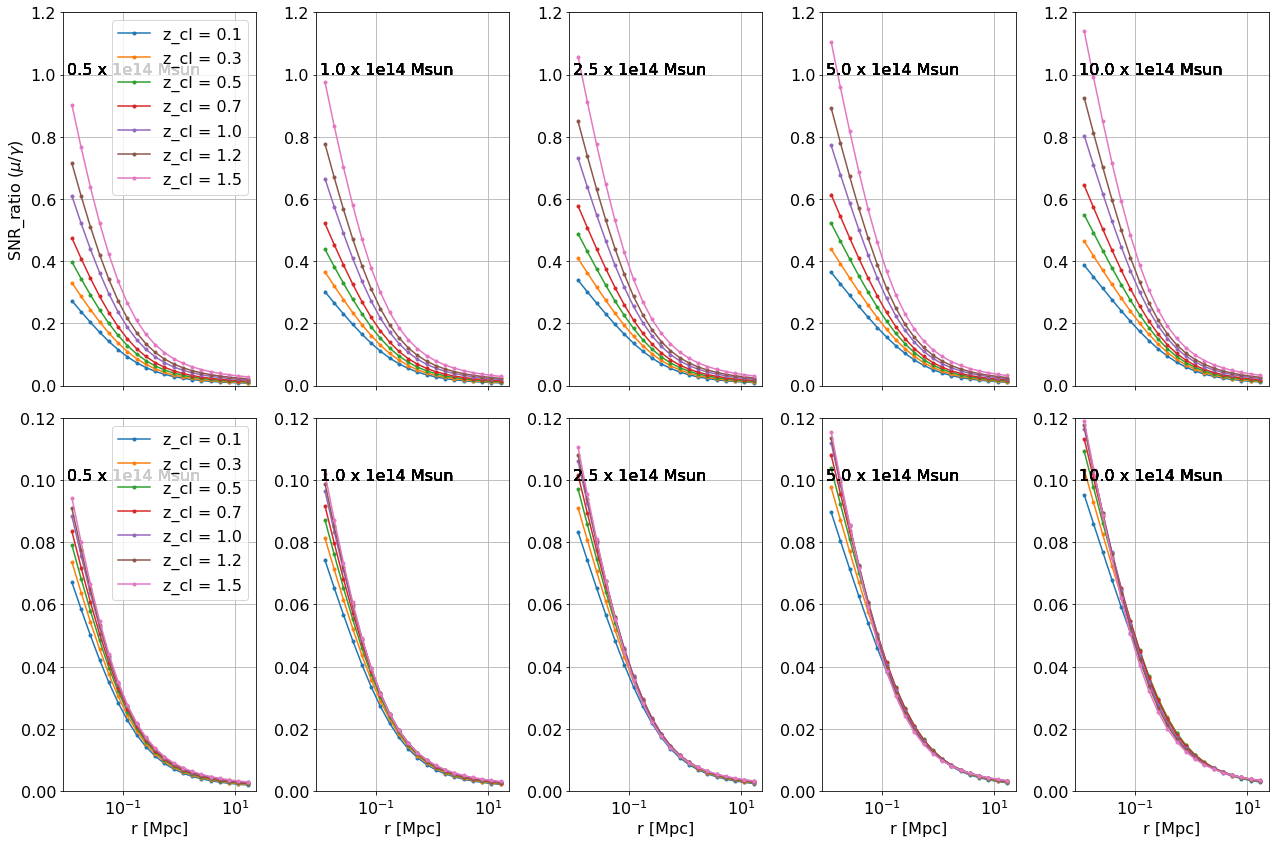

In [131]:
fig, ax = plt.subplots(2, len(mass),  figsize=(18,12), sharex=True, sharey=False)

for j in range(len(lens_redshift)):
    for i in range(len(mass)):  
        #ax1.errorbar(bin_center, model[:,i], xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center], yerr = noise ,fmt='x', label = 'mass = '+str(mass[i]/1e14) + ' x 1e14 Msun')
        ax[0,i].plot(bin_center_s[:,j], (model_mu_lbg[:,i, j]/noise_mu_lbg[:,j])/(model_s[:,i, j]/noise_s[:,j]), '.-',  label = 'z_cl = '+str(lens_redshift[j]))
        ax[1,i].plot(bin_center_mu_qso[:,j], (model_mu_qso[:,i, j]/noise_mu_qso[:,j])/(model_s[:,i, j]/noise_s[:,j]), '.-',  label = 'z_cl = '+str(lens_redshift[j]))
        ax[1,i].set_xlabel('r [' + radial_unit + ']');
        #ax[0,i].set_yscale('log')
        #ax[1,i].set_yscale('log')
        #ax[0,i].set_ylim(1e-3,5)
        #ax[1,i].set_ylim(1e-3,0.3)
        ax[0,i].set_ylim(0,1.2)
        ax[1,i].set_ylim(0,0.12)
        ax[0,i].grid()
        ax[1,i].grid()
        ax[0,i].text(0.01,1., str(mass[i]/1e14) + ' x 1e14 Msun')
        ax[1,i].text(0.01,0.1, str(mass[i]/1e14) + ' x 1e14 Msun')
    
ax[0,0].legend()
ax[1,0].legend()


ax[0,0].set_xscale('log')
ax[0,0].set_ylabel("SNR_ratio ($\mu/\gamma$)")

fig.tight_layout()

# **3) Chi2 computation**

In [132]:
def mass_minimization(chi2_val, mass_guess, s = np.array([1.,2.,3.]) ):
    chi2_val_itp_up = interpolate.interp1d(chi2_val[np.argmin(chi2_val) :], mass_guess[np.argmin(chi2_val) :], bounds_error= False)
    chi2_val_itp_low = interpolate.interp1d(chi2_val[: np.argmin(chi2_val) + 1], mass_guess[: np.argmin(chi2_val) + 1], bounds_error= False)
    
    chi2_eval = stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1)
    
    eval_mass = mass_guess[np.argmin(chi2_val)]
    eval_mass_min = chi2_val_itp_low(np.min(chi2_val) + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
    eval_mass_max = chi2_val_itp_up(np.min(chi2_val)  + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
    
    return eval_mass, eval_mass_min, eval_mass_max

In [133]:
def chi2 (data, error, model):
    chi2 = (data - model)**2/error**2
    return np.sum(chi2)

In [134]:
lens_redshift = 0.5
radial_unit, rmin, rmax = 'Mpc', 0.01, 10
#radial_unit, rmin, rmax =  'arcmin', 0.2, 50
profile_type = "magnification QSO"

In [135]:
mass_guess = np.logspace(12,16,400, base=10)

In [136]:
bin_center, bin_edges, model, noise = profile_determination(rmin, rmax, radial_unit , lens_redshift, mass , profile_type , dict_profile, cosmo,   nbins=20, method='evenlog10width', \
                                                            conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift, statistic='mean')[0], delta_mdef=200)

In [137]:
model_guess = modele_determination(bin_center, radial_unit, lens_redshift, mass_guess, profile_type, dict_profile, cosmo, \
                                   conc=concentration.modelDiemer19(mass_guess*cosmo.h, lens_redshift, statistic='mean')[0], delta_mdef=200, zinf=1e10)

In [138]:
i  = 4

chi2_val = np.zeros(len(mass_guess))

for j in range(len(mass_guess)):
    chi2_val[j] = chi2(model[:,i], noise, model_guess[:,j])

In [139]:
eval_mass, eval_mass_min, eval_mass_max = mass_minimization(chi2_val, mass_guess, s = np.array([1.,2.,3.]))

print( "evaluated mass =, %1.2e" % eval_mass)
[print ("sigma =", np.array([1.,2.,3.])[i], ", min mass =", "%1.2e" % eval_mass_min[i], ", max mass =", "%1.2e" % eval_mass_max[i]) for i in range(3)];

evaluated mass =, 9.94e+14
sigma = 1.0 , min mass = nan , max mass = nan
sigma = 2.0 , min mass = nan , max mass = nan
sigma = 3.0 , min mass = nan , max mass = nan


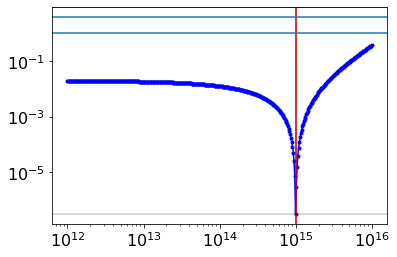

In [140]:
plt.plot(mass_guess, chi2_val,'b.-')

plt.xscale('log')
plt.yscale('log')

plt.axvline(mass[i], color='red')
plt.axhline(np.min(chi2_val),  color='black', alpha=0.2)
plt.axvline(eval_mass,  color='black', alpha=0.2)
[plt.axhline(np.min(chi2_val)+i) for i in stats.chi2.ppf(stats.chi2.cdf( np.array([1.,2.,3.])**2,1), 1)];

[plt.axvline(eval_mass_min[i], alpha=0.5) for i in range(3)];
[plt.axvline(eval_mass_max[i], alpha=0.5) for i in range(3)];

In [141]:
lens_redshift = z_cl
radial_unit, rmin, rmax = 'Mpc', 0.2, 3.5
nbins = 7
method = 'evenlog10width'

In [142]:
bin_center_s, noise_s = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_s = np.zeros((nbins + 1, len(lens_redshift)))
model_s = np.zeros((nbins, len(mass), len(lens_redshift)))

for i in range(len(lens_redshift)):
    bin_center_s[:,i], bin_edges_s[:,i], model_s[:,:,i], noise_s[:,i] = profile_determination(rmin, rmax, radial_unit , lens_redshift[i], mass , "reduced shear",\
                                                                                              dict_profile, cosmo,   nbins=nbins, method=method,\
                                                                                              conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200)

In [143]:
bin_center_mu_lbg, noise_mu_lbg = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_lbg = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_lbg = np.zeros((nbins, len(mass), len(lens_redshift)))

for i in range(len(lens_redshift)):
    bin_center_mu_lbg[:,i], bin_edges_mu_lbg[:,i], model_mu_lbg[:,:,i], noise_mu_lbg[:,i] = profile_determination(rmin, rmax, radial_unit , lens_redshift[i], mass , "magnification LBG" ,\
                                                                                                                  dict_profile, cosmo,   nbins=nbins, method=method,\
                                                                                                                  conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200)

In [144]:
bin_center_mu_qso, noise_mu_qso = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_qso = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_qso = np.zeros((nbins, len(mass), len(lens_redshift)))

for i in range(len(lens_redshift)):
    bin_center_mu_qso[:,i], bin_edges_mu_qso[:,i], model_mu_qso[:,:,i], noise_mu_qso[:,i] = profile_determination(rmin, rmax, radial_unit , lens_redshift[i], mass , "magnification QSO" , \
                                                                                                                  dict_profile, cosmo,   nbins=nbins, method=method,\
                                                                                                                  conc=concentration.modelDiemer19(mass*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200)

In [145]:
mass_guess = np.logspace(12,16,400, base=10)

In [146]:
model_guess_s, model_guess_mu_lbg, model_guess_mu_qso = np.zeros((3, bin_center_s[:,0].size, len(mass_guess), len(lens_redshift)))

for i in range(len(lens_redshift)):
    model_guess_s[:,:,i]      = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'reduced shear', \
                                                     dict_profile, cosmo, conc=concentration.modelDiemer19(mass_guess*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200, zinf=1e10)
    model_guess_mu_lbg[:,:,i] = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'magnification LBG',\
                                                     dict_profile, cosmo, conc=concentration.modelDiemer19(mass_guess*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200, zinf=1e10)
    model_guess_mu_qso[:,:,i] = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'magnification QSO',\
                                                     dict_profile, cosmo, conc=concentration.modelDiemer19(mass_guess*cosmo.h, lens_redshift[i], statistic='mean')[0], delta_mdef=200, zinf=1e10)

In [158]:
chi2_val_s = np.zeros((len(mass_guess), len(mass),  len(lens_redshift)))
chi2_val_mu_lbg = np.zeros((len(mass_guess), len(mass),  len(lens_redshift)))
chi2_val_mu_qso = np.zeros((len(mass_guess), len(mass),  len(lens_redshift)))

N_S   = 1.
N_LBG = 1.
N_QSO = 1.

for i in range(len(lens_redshift)):
    for j in range(len(mass)):
        for k in range(len(mass_guess)):
            chi2_val_s[k, j,i] = chi2(model_s[:,j,i], noise_s[:,i]/np.sqrt(N_S), model_guess_s[:,k,i])
            chi2_val_mu_lbg[k, j,i] = chi2(model_mu_lbg[:,j,i], noise_mu_lbg[:,i]/np.sqrt(N_LBG), model_guess_mu_lbg[:,k,i])
            chi2_val_mu_qso[k, j,i] = chi2(model_mu_qso[:,j,i], noise_mu_qso[:,i]/np.sqrt(N_QSO), model_guess_mu_qso[:,k,i])

In [ ]:
eval_mass_s, eval_mass_min_s, eval_mass_max_s = np.zeros((3, len(mass),  len(lens_redshift)))
eval_mass_mu_lbg, eval_mass_min_mu_lbg, eval_mass_max_mu_lbg = np.zeros((3, len(mass),  len(lens_redshift)))
eval_mass_mu_qso, eval_mass_min_mu_qso, eval_mass_max_mu_qso = np.zeros((3, len(mass),  len(lens_redshift)))

for i in range(len(lens_redshift)):
    for j in range(len(mass)):
        eval_mass_s[j,i], eval_mass_min_s[j,i], eval_mass_max_s[j,i] = mass_minimization(chi2_val_s[:, j,i], mass_guess, s = 1.)
        eval_mass_mu_lbg[j,i], eval_mass_min_mu_lbg[j,i], eval_mass_max_mu_lbg[j,i] = mass_minimization(chi2_val_mu_lbg[:, j,i], mass_guess, s = 1.)
        eval_mass_mu_qso[j,i], eval_mass_min_mu_qso[j,i], eval_mass_max_mu_qso[j,i] = mass_minimization(chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)

In [ ]:
eval_mass_comb, eval_mass_min_comb, eval_mass_max_comb  = np.zeros((3, len(mass),  len(lens_redshift)))
eval_mass_comb_mu, eval_mass_min_comb_mu, eval_mass_max_comb_mu  = np.zeros((3, len(mass),  len(lens_redshift)))

for i in range(len(lens_redshift)):
    for j in range(len(mass)):
        eval_mass_comb[j,i], eval_mass_min_comb[j,i], eval_mass_max_comb[j,i] = mass_minimization(chi2_val_s[:, j,i] + chi2_val_mu_lbg[:, j,i] + chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)
        eval_mass_comb_mu[j,i], eval_mass_min_comb_mu[j,i], eval_mass_max_comb_mu[j,i] = mass_minimization(chi2_val_mu_lbg[:, j,i] + chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)

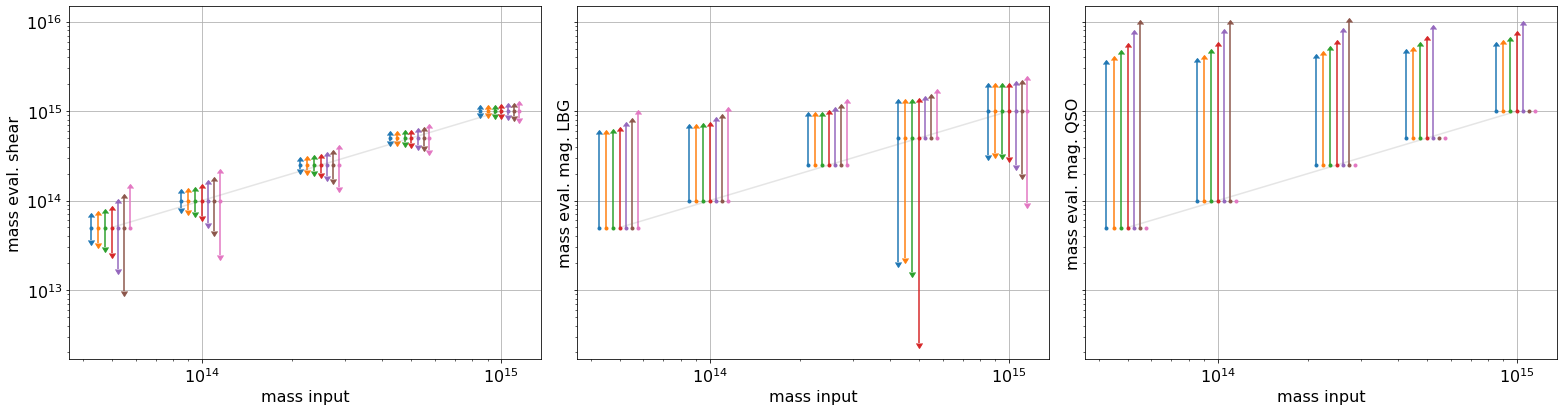

In [156]:
decal = 1 + np.linspace(-0.15,0.15,len(z_cl))

fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(22,6), sharex=True, sharey=True)

[ax1.errorbar(mass*decal[i], eval_mass_s[:,i], yerr = [eval_mass_s[:,i] - eval_mass_min_s[:,i], eval_mass_max_s[:,i] - eval_mass_s[:,i]], lolims=True, uplims=True, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax2.errorbar(mass*decal[i], eval_mass_mu_lbg[:,i], yerr = [eval_mass_mu_lbg[:,i] - eval_mass_min_mu_lbg[:,i], eval_mass_max_mu_lbg[:,i] - eval_mass_mu_lbg[:,i]], lolims=True, uplims=True ,fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax3.errorbar(mass*decal[i], eval_mass_mu_qso[:,i], yerr = [eval_mass_mu_qso[:,i] - eval_mass_min_mu_qso[:,i], eval_mass_max_mu_qso[:,i] - eval_mass_mu_qso[:,i]], lolims=True, uplims=True ,fmt='.', label="z =" +str(z_cl[i]) ) for i in range(len(lens_redshift))];
    
    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylabel("mass eval. shear");
ax2.set_ylabel("mass eval. mag. LBG");
ax3.set_ylabel("mass eval. mag. QSO");

for i in (ax1,ax2,ax3):
    i.plot(mass, mass,alpha=0.2)
    i.set_xlabel("mass input")
    i.grid()
    #i.legend(loc='lower right',frameon=False)
    
fig.tight_layout()

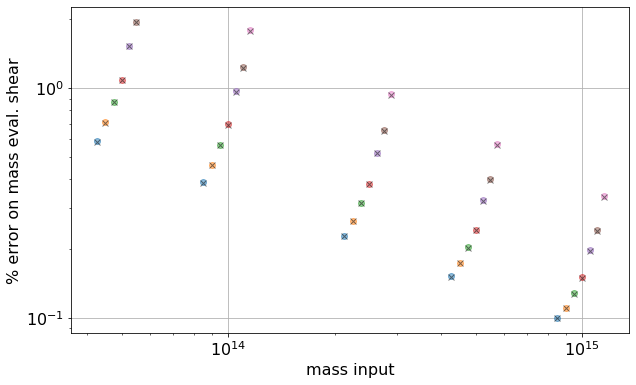

In [157]:
#relative error on mass from shear alone and shear + magnification (QSO & LBG) combined

fig, ax1= plt.subplots(1,1,  figsize=(10,6), sharex=True, sharey=True)

[ax1.plot(mass*decal[i], (eval_mass_max_s[:,i]  - eval_mass_min_s[:,i])/ eval_mass_s[:,i] ,'o' , alpha=0.5, label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax1.plot(mass*decal[i], (eval_mass_max_comb[:,i]  - eval_mass_min_comb[:,i])/ eval_mass_comb[:,i] ,'kx',alpha=0.5) for i in range(len(lens_redshift))];

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel("mass input")
ax1.set_ylabel("% error on mass eval. shear");
ax1.grid()

#ax1.legend()

# A TRIER

In [211]:
def masking_frac(rad):
    fmask = 1/30. * rad**(-0.5)
    return fmask

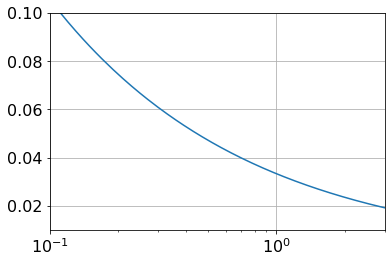

In [212]:
plt.plot(r3d,   masking_frac(r3d))
plt.xscale('log')

plt.xlim(0.1, 3)
plt.ylim(0.01,0.1)

plt.grid()

# SNR of the magnification

# SNR RATIO

### SNR$_{\gamma}$/SNR$_{\mu} = \sqrt{\frac{N_{\gamma}}{N_{\mu}}}\frac{|\gamma_\inf|}{\kappa_{inf}}\frac{1}{2(|\alpha - 1|)\sigma_e}$

## $ \frac{|\gamma_\inf|}{\kappa_{inf}} = \frac{\Delta\Sigma (R)} {\Sigma (R)}$

## TEST